In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.archive.signal import *

In [2]:
client = MarketDataClient(bucket="market-data-consolidated-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 1,
    "security_id": 3,
    "start_datetime": datetime.datetime(2025, 4, 7),
    "end_datetime": datetime.datetime(2025, 4, 13),
    "schema_type": SchemaType.MBP_10,
}

strategies = [Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_mean_500_delta'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta_alpha_00001'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta_alpha_0001'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_moving_average_crossover'], minimum_ticker_cycle=3, starting_cash=100000.0)]
# strategies = [Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta'], minimum_ticker_cycle=3, starting_cash=100000.0),]

backtest = Backtest(
    client=client,
    strategies=strategies,  # Pass a list of strategies
    exchange_id=client_data_params["exchange_id"],
    security_id=client_data_params["security_id"],
    start_datetime=client_data_params["start_datetime"],
    end_datetime=client_data_params["end_datetime"],
    schema_type=client_data_params["schema_type"]
)

In [3]:
outputs_list = backtest.run(data_type='pandas')

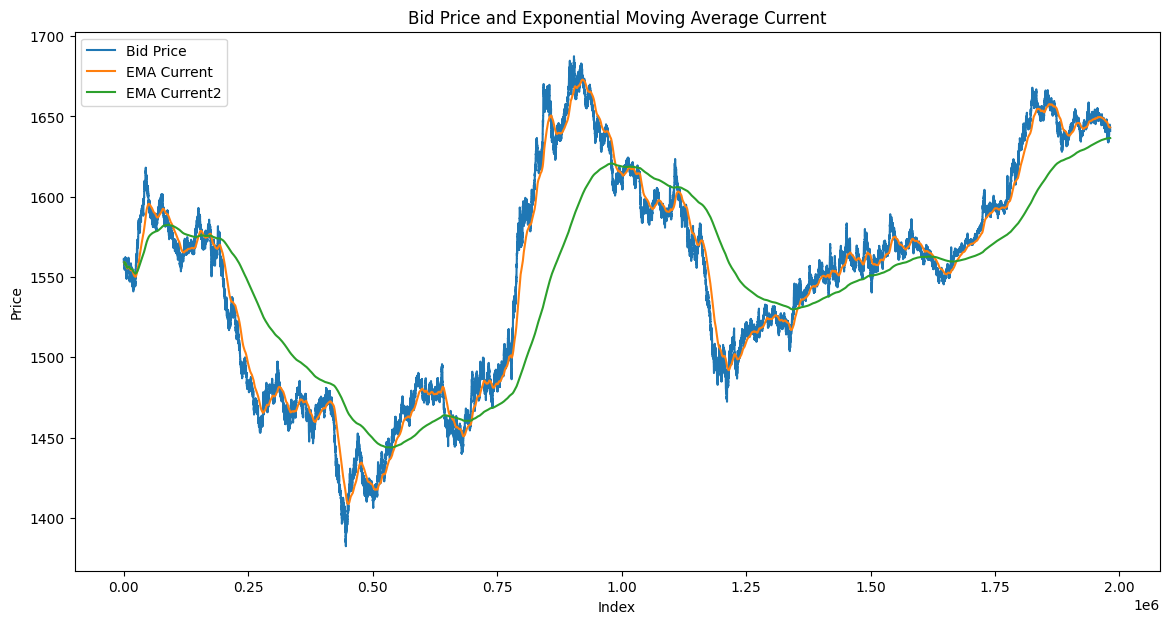

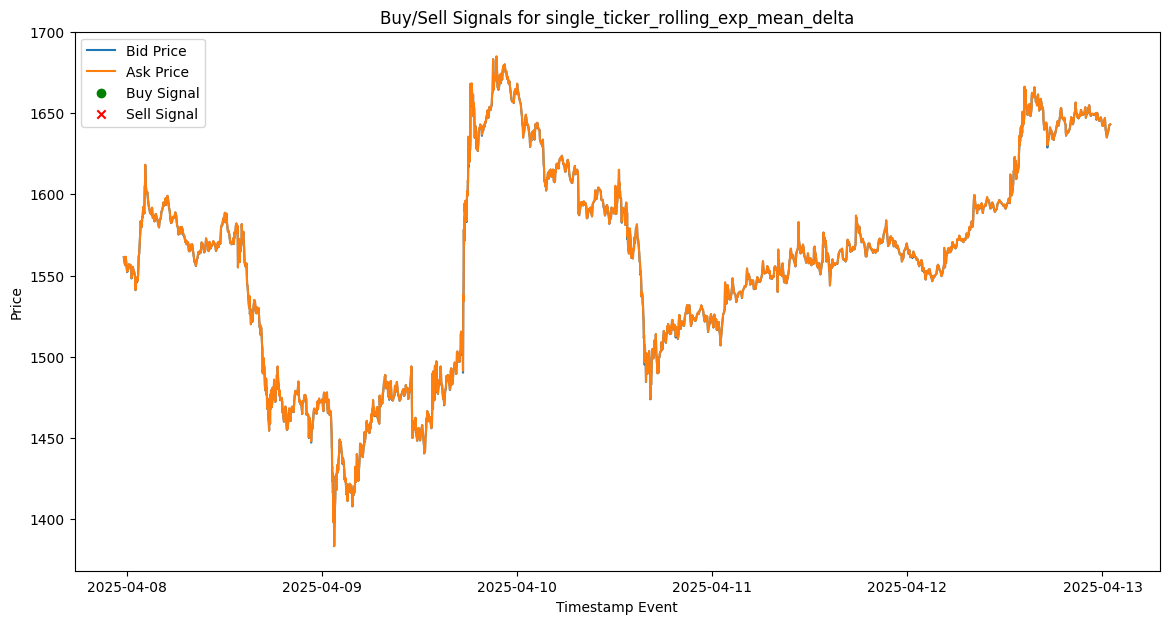

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot bid and ask prices once, as the data is the same for each strategy
sampled_df = outputs_list[0][0].iloc[::1000, :]  # Sample every 1000th row from the first output


# Plot the Exponential Moving Average (EMA) Delta and the shifted EMA Delta
span = 500000  # Assuming the span is 50000 as per the function definition
ema_current = outputs_list[0][0]['bidPrice0'].ewm(com=None, span=None, halflife=None, alpha=.0001, min_periods=1000).mean()
ema_current2 = outputs_list[0][0]['bidPrice0'].ewm(com=None, span=None, halflife=None, alpha=.00001, min_periods=1000).mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=outputs_list[0][0], x=outputs_list[0][0].index, y=outputs_list[0][0]['bidPrice0'], label='Bid Price')
sns.lineplot(data=outputs_list[0][0], x=outputs_list[0][0].index, y=ema_current, label='EMA Current')
sns.lineplot(data=outputs_list[0][0], x=outputs_list[0][0].index, y=ema_current2, label='EMA Current2')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Bid Price and Exponential Moving Average Current')
plt.legend()
plt.show()


# Create the plot for buy/sell signals for each strategy
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    # Sample every 1000th row for the current strategy's output
    sampled_df = output_df.iloc[::1000, :]

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=sampled_df, x='timestampEvent', y='bidPrice0', label='Bid Price')
    sns.lineplot(data=sampled_df, x='timestampEvent', y='askPrice0', label='Ask Price')
    plt.xlabel('Timestamp Event')
    plt.ylabel('Price')
    plt.title('Bid and Ask Prices')


    # Add green and red dots for actions specific to each strategy
    buy_signals = sampled_df[sampled_df[f'{action_name}_cash_action'] > 0]
    sell_signals = sampled_df[sampled_df[f'{action_name}_cash_action'] < 0]

    plt.scatter(buy_signals['timestampEvent'], buy_signals['askPrice0'], color='green', label='Buy Signal', marker='o')
    plt.scatter(sell_signals['timestampEvent'], sell_signals['askPrice0'], color='red', label='Sell Signal', marker='x')

    plt.xlabel('Timestamp Event')
    plt.ylabel('Price')
    plt.title(f'Buy/Sell Signals for {action_name}')
    plt.legend()
    plt.show()


/Users/andrewannetrand/Desktop/gnomepy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


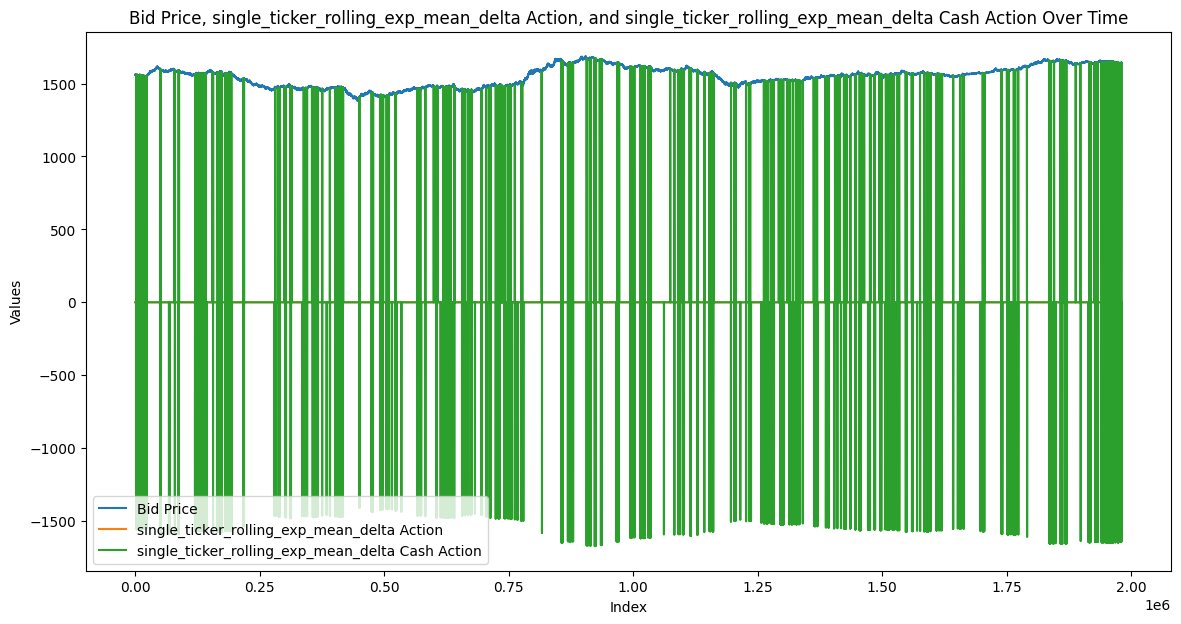

In [5]:
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    plt.figure(figsize=(14, 7))
    
    # Plot bidPrice0
    sns.lineplot(data=output_df, x=output_df.index, y='bidPrice0', label='Bid Price')
    
    # Plot action_name_action
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_action', label=f'{action_name} Action')
    
    # Plot action_name_cash_action
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_cash_action', label=f'{action_name} Cash Action')
    
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Bid Price, {action_name} Action, and {action_name} Cash Action Over Time')
    plt.legend()
    plt.show()


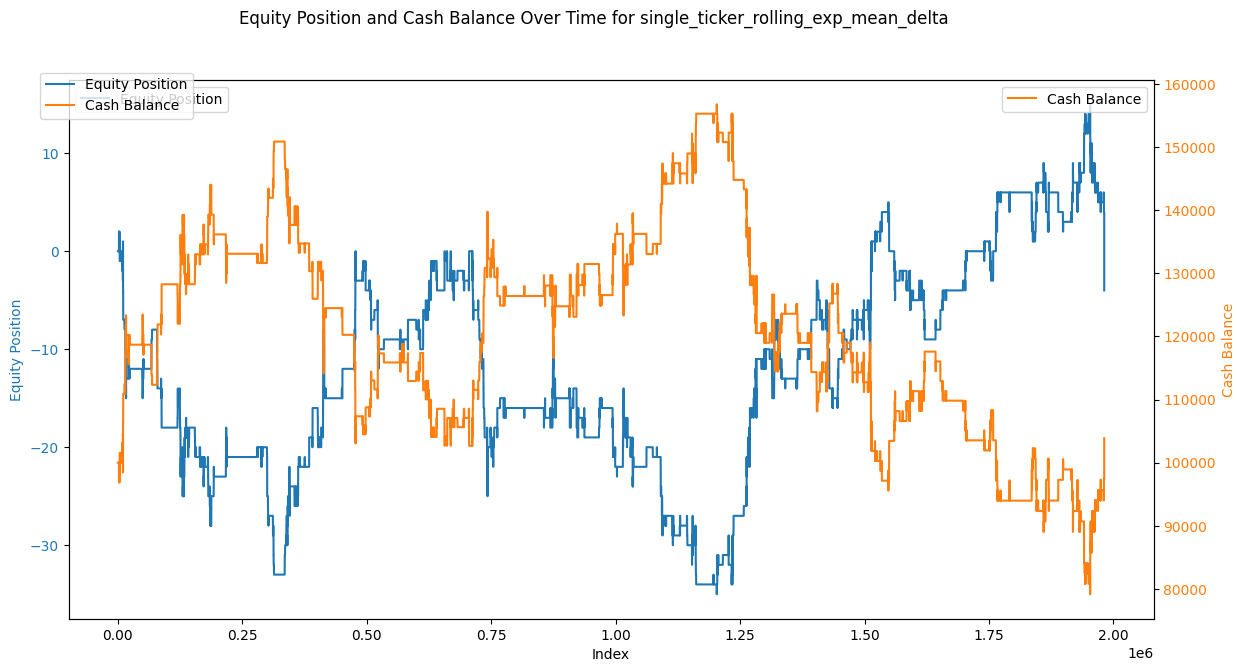

In [6]:
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Equity Position on the first y-axis
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Equity Position', color='tab:blue')
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_equity_position', label='Equity Position', ax=ax1, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for Cash Balance
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cash Balance', color='tab:orange')
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_cash_balance', label='Cash Balance', ax=ax2, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add title and legend
    fig.suptitle(f'Equity Position and Cash Balance Over Time for {action_name}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

In [7]:
# Summarize the backtest results for each strategy
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    starting_cash = strategy.starting_cash
    ending_cash = output_df[f'{action_name}_cash_balance'].iloc[-1]
    number_of_trades = len(output_df[output_df[f'{action_name}_cash_action'] != 0])
    frequency_of_trades = len(output_df) / number_of_trades if number_of_trades > 0 else 0 # Ticks per trade
    mro = (ending_cash - starting_cash) / starting_cash

    # Calculate the number of buy and sell actions
    number_of_buys = len(output_df[output_df[f'{action_name}_cash_action'] > 0])
    number_of_sells = len(output_df[output_df[f'{action_name}_cash_action'] < 0])

    summary = {
        "Starting Cash": starting_cash,
        "Ending Cash": ending_cash,
        "Number of Trades": number_of_trades,
        "Frequency of Trades": frequency_of_trades,
        "MRO": mro,
        "Number of Buys": number_of_buys,
        "Number of Sells": number_of_sells
    }

    print(f"Backtest Summary for {action_name}:")
    for key, value in summary.items():
        print(f"{key}: {value}")
    print()  # Add a newline for better readability between summaries


Backtest Summary for single_ticker_rolling_exp_mean_delta:
Starting Cash: 100000.0
Ending Cash: 103879.50000000004
Number of Trades: 1450
Frequency of Trades: 1366.4793103448276
MRO: 0.03879500000000043
Number of Buys: 723
Number of Sells: 727

